<a href="https://colab.research.google.com/github/ZahraReyhanian/DGM/blob/main/Prompt_engineering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Install and Import necessary libraries

In [ ]:
!pip install datasets &>> install.log

In [ ]:
!pip install transformers

In [ ]:
!pip install sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 7.0 MB/s eta 0:00:00


In [ ]:
!pip install accelerate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 265.7/265.7 kB 1.7 MB/s eta 0:00:00


In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
from datasets import load_dataset
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import re

# Load Dataset

In [ ]:
test_ds = load_dataset("lukaemon/bbh", 'sports_understanding')
test_ds

Generating test split:   0%|          | 0/250 [00:00<?, ? examples/s]

DatasetDict({
    test: Dataset({
        features: ['input', 'target'],
        num_rows: 250
    })
})

In [ ]:
train_ds = load_dataset("tasksource/bigbench",'sports_understanding')
train_ds

/usr/local/lib/python3.10/dist-packages/datasets/load.py:1429: FutureWarning: The repository for tasksource/bigbench contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/tasksource/bigbench
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


Generating train split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

DatasetDict({
    train: Dataset({
        features: ['inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores', 'idx'],
        num_rows: 789
    })
    validation: Dataset({
        features: ['inputs', 'targets', 'multiple_choice_targets', 'multiple_choice_scores', 'idx'],
        num_rows: 197
    })
})

# Create Model

In [ ]:
tokenizer = T5Tokenizer.from_pretrained("google/flan-t5-large")
model = T5ForConditionalGeneration.from_pretrained("google/flan-t5-large", device_map="auto")

input_text = "translate English to German: How old are you?"
input_ids = tokenizer(input_text, return_tensors="pt").input_ids.to("cuda")

outputs = model.generate(input_ids)
print(tokenizer.decode(outputs[0]))

tokenizer_config.json:   0%|          | 0.00/2.54k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thouroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565
Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


config.json:   0%|          | 0.00/662 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/3.13G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/147 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


<pad> Wie alte sind Sie?</s>


# Prompt Engineering

In [ ]:
CLEANR = re.compile('<.*?>')

def clean_text(raw_html):
  cleantext = re.sub(CLEANR, '', raw_html)
  return cleantext

## answer-only

In [ ]:
s = 0
test_size = len(test_ds['test'])
ao_data = {"prompt": [],
           "correct answer": [],
           "model answer": []
           }

for index in range(test_size):
    question = test_ds['test'][index]['input']
    answer = test_ds['test'][index]['target']

    prompt = f"Answer the following question with just yes or no. {question}"

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(input_ids)
    result = clean_text(tokenizer.decode(outputs[0])).strip().lower()

    print(f"============================== Experiment {index+1} ==============================")
    print(prompt)
    print("Model says:")
    print(result)
    print("Correct answer:")
    print(answer)

    ao_data["prompt"].append(prompt)
    ao_data["correct answer"].append(answer)
    ao_data["model answer"].append(result)

    s += answer == result

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


============================== Experiment 1 ==============================
Answer the following question with just yes or no. Is the following sentence plausible? "Elias Lindholm beat the buzzer."
Model says:
yes
Correct answer:
no
============================== Experiment 2 ==============================
Answer the following question with just yes or no. Is the following sentence plausible? "John Carlson scored in the third period."
Model says:
yes
Correct answer:
yes
============================== Experiment 3 ==============================
Answer the following question with just yes or no. Is the following sentence plausible? "Marcelo got on the end of a through ball."
Model says:
no
Correct answer:
yes
============================== Experiment 4 ==============================
Answer the following question with just yes or no. Is the following sentence plausible? "Deshaun Watson was called for the goal tend in the Eastern Conference Finals."
Model says:
no
Correct answer:
no
=======

In [ ]:
accuracy = s/test_size
print("Accuracy:",accuracy)

Accuracy: 0.544


In [ ]:
df = pd.DataFrame(ao_data)

# Save the dataframe to a CSV file
df.to_csv('answer_only_data.csv', index=False)

## 3-shot

In [ ]:
def make_prompt_with_example(example_indices_full, index_to_answer):
    prompt = ""
    for index in example_indices_full:
        input = train_ds["train"][index]['inputs']
        answer = train_ds["train"][index]['targets'][0]

        prompt += f"""
Q: Answer the following yes/no question.
{input.strip()}

A:{'yes' if answer=='plausible' else 'no'}

        """
    input = test_ds["test"][index_to_answer]['input']
    prompt += f"""
yes/no question.

{input.strip()}

A:
    """

    return prompt

In [ ]:
s = 0
fshot_data = {"prompt": [],
           "correct answer": [],
           "model answer": []
           }

for index in range(test_size):
    question = test_ds['test'][index]['input']
    answer = test_ds['test'][index]['target']

    prompt = make_prompt_with_example([0,1,2], index)

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(input_ids)
    result = clean_text(tokenizer.decode(outputs[0])).strip().lower()

    print(f"============================== Experiment {index+1} ==============================")
    print(prompt)
    print("Model says:")
    print(result)
    print("Correct answer:")
    print(answer)


    fshot_data["prompt"].append(prompt)
    fshot_data["correct answer"].append(answer)
    fshot_data["model answer"].append(result)

    s += answer == result

/usr/local/lib/python3.10/dist-packages/transformers/generation/utils.py:1273: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


Streaming output truncated to the last 5000 lines.
Statement: Trevor Bauer swung to protect the runner in the World Series
Plausible/implausible?

A:yes

        
Q: Answer the following yes/no question.
Determine whether the following statement or statements are plausible or implausible:
Statement: Juan Soto hit the slant pass in the NFC divisional round
Plausible/implausible?

A:no

        
Q: Answer the following yes/no question.
Determine whether the following statement or statements are plausible or implausible:
Statement: Marouane Fellaini scored a freekick
Plausible/implausible?

A:yes

        
yes/no question.

Is the following sentence plausible? "Jesus Luzardo was called for slashing."

A:
    
Model says:
no
Correct answer:
no
============================== Experiment 113 ==============================

Q: Answer the following yes/no question.
Determine whether the following statement or statements are plausible or implausible:
Statement: Trevor Bauer swung to protect the 

In [ ]:
accuracy_3shot = s/test_size
print("Accuracy:",accuracy_3shot)

Accuracy: 0.564


In [ ]:
df = pd.DataFrame(fshot_data)

# Save the dataframe to a CSV file
df.to_csv('few_shot_data.csv', index=False)

## COT

In [ ]:
s = 0
cot_data = {"prompt": [],
           "correct answer": [],
           "model answer": []
           }

for index in range(test_size):
    question = test_ds['test'][index]['input']
    answer = test_ds['test'][index]['target']

    prompt = f"""
Answer the following yes/no question by reasoning step-by-step and then say this answer is yes or no.

{question}
"""

    input_ids = tokenizer(prompt, return_tensors="pt").input_ids.to("cuda")

    outputs = model.generate(input_ids, max_new_tokens=64)
    result = clean_text(tokenizer.decode(outputs[0])).strip().lower()

    print(f"============================== Experiment {index+1} ==============================")
    print(prompt)
    print("Model says:")
    print(result)
    print("Correct answer:")
    print(answer)

    cot_data["prompt"].append(prompt)
    cot_data["correct answer"].append(answer)
    cot_data["model answer"].append(result)

    s += answer == result.split()[-1][:-1]

============================== Experiment 1 ==============================

Answer the following yes/no question by reasoning step-by-step and then say this answer is yes or no. 

Is the following sentence plausible? "Elias Lindholm beat the buzzer."

Model says:
elias lindholm is a famous tennis player and he won the wimbledon championships. so, the final answer is yes.
Correct answer:
no
============================== Experiment 2 ==============================

Answer the following yes/no question by reasoning step-by-step and then say this answer is yes or no. 

Is the following sentence plausible? "John Carlson scored in the third period."

Model says:
john carlson is a football player who scored in the third period. so, the final answer is yes.
Correct answer:
yes
============================== Experiment 3 ==============================

Answer the following yes/no question by reasoning step-by-step and then say this answer is yes or no. 

Is the following sentence plausible? "M

In [ ]:
accuracy_cot = s/test_size
print("Accuracy:",accuracy_cot)

Accuracy: 0.592


In [ ]:
df = pd.DataFrame(cot_data)

# Save the dataframe to a CSV file
df.to_csv('COT_data.csv', index=False)

# Visualization

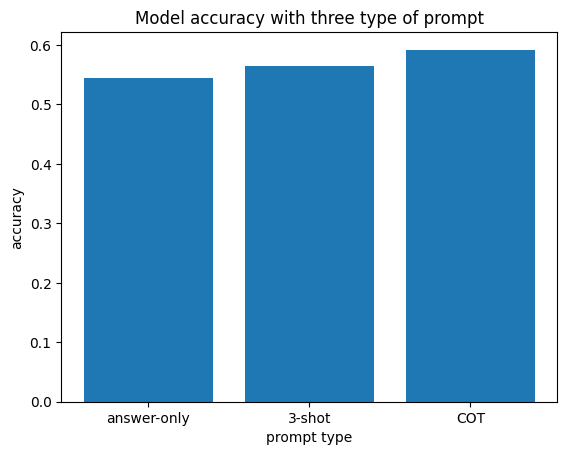

In [ ]:
plt.bar(["answer-only", "3-shot", "COT"], [accuracy, accuracy_3shot, accuracy_cot])
plt.title("Model accuracy with three type of prompt")
plt.xlabel("prompt type")
plt.ylabel("accuracy")
plt.show()